2024-12-05 12:23:26.045920: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-05 12:23:26.285785: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Appending path to carla module /home/ignacy/research/betaRCE/src/explainers/CARLA
Appending path to carla module /home/ignacy/research/betaRCE/src/explainers/CARLA


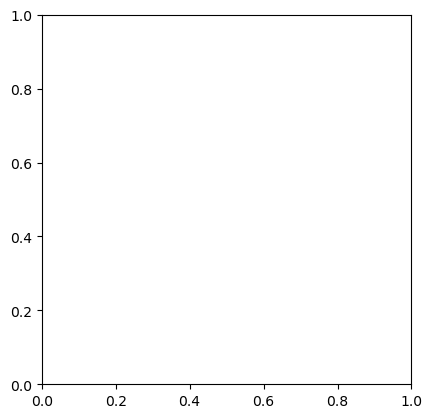

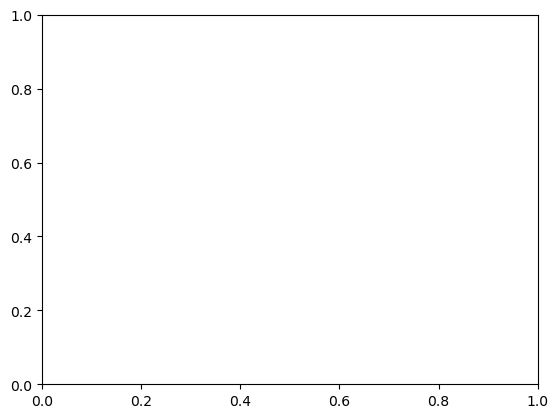

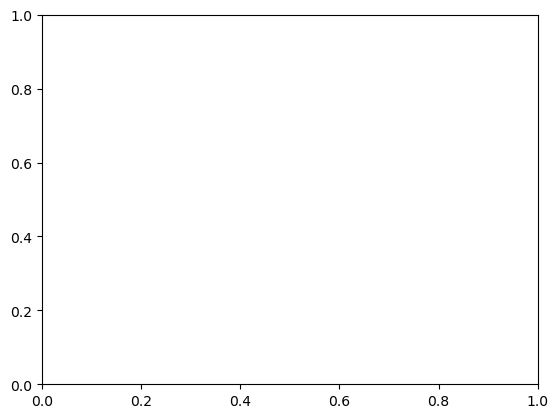

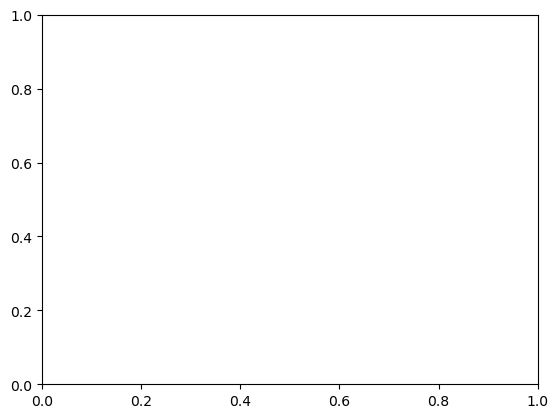

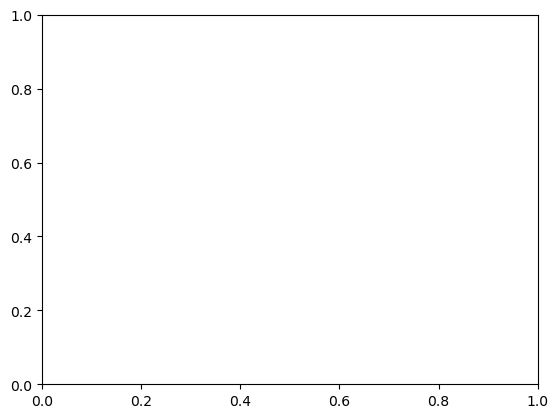

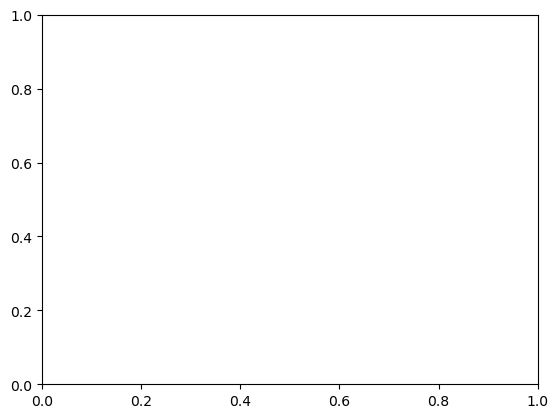

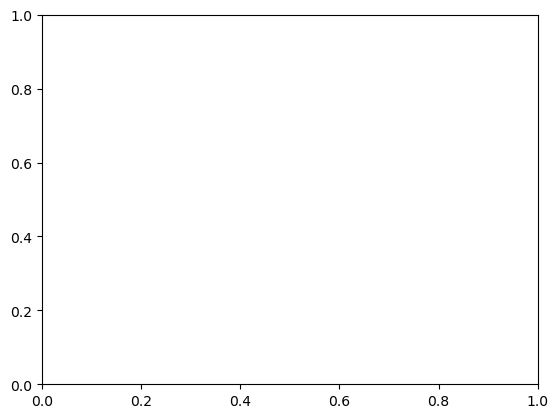

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.datasets import Dataset, DatasetPreprocessor
from src.experiments_utils import (
    train_model,
    train_B,
    base_counterfactual_generate,
    prepare_base_counterfactual_explainer,
)


In [5]:
dataset = Dataset("moons")
dataset_preprocessor = DatasetPreprocessor(
    dataset=dataset,
    random_state=1,
    one_hot=True,
)

In [6]:
X_train_pd, X_test_pd, y_train, y_test = dataset_preprocessor.get_data()
X_train, X_test = [x.to_numpy() for x in (X_train_pd, X_test_pd)]

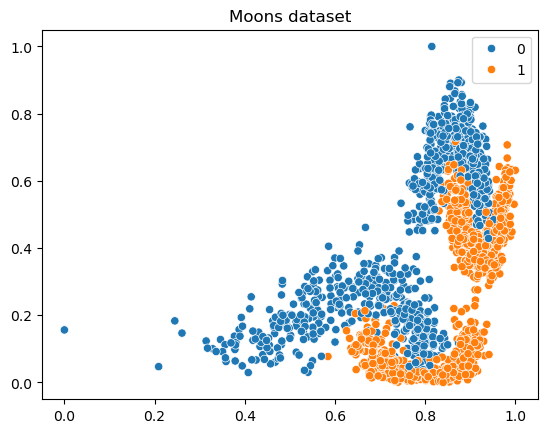

In [ ]:
# Visualize data
fig, ax = plt.subplots()
sns.scatterplot(x=X_train[:, 0] ** (1 / 3), y=X_train[:, 1] ** 2, hue=y_train, ax=ax)
ax.set_title("Moons dataset")
plt.show()

In [33]:
hparams = {
    "loss": "BCELoss",
    "early_stopping": True,
    "lr": 0.05,
    "epochs": 10,
    "batch_size": 128,
    "verbose": True,
    "dropout": 0.4,
    "classification_threshold": 0.5,
    "hidden_layers": 3,
    "neurons_per_layer": 128,
    "activation": "relu",
    "optimizer": "adam",
}
model1, pred_proba1, pred_crisp1 = train_model(
    X_train, y_train, "neural_network", 1, hparams
)

modelsB = []
for i in range(16):
    # hparams['neurons_per_layer'] /= 2
    modelB, pred_probaB, pred_crispB = train_model(
        X_train, y_train, "neural_network", 1, hparams
    )
    modelsB.append(modelB)

In [34]:
beta_gs_hparams = {
    "max_iter": 100,
    "n_search_samples": 100,
    "p_norm": 2,
    "step": 0.1,
    "target_proba": 0.5,
}


base_explainer = prepare_base_counterfactual_explainer(
    base_cf_method="gs",
    hparams=beta_gs_hparams,
    model=model1,
    X_train=X_train_pd,
    y_train=y_train,
    dataset_preprocessor=dataset_preprocessor,
    predict_fn_1_crisp=pred_crisp1,
)

In [35]:
i = 60
x_test_sample = X_test[i]
y_test_sample = y_test[i]
x_test_sample_pd = pd.DataFrame(x_test_sample.reshape(1, -1), columns=X_test_pd.columns)

In [3]:
import sklearn.datasets
import sklearn.linear_model
import sklearn.neighbors
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data = sklearn.datasets.make_moons(n_samples=1000, noise=0.3)

data_X, data_y = data

# Rotate data by 90 degrees
rot = np.array([[0, -1], [1, 0]])
data_X = np.dot(data_X, rot)


classifiers = []
for i in range(5, 20, 1):
    act = np.random.choice(["identity", "logistic", "tanh", "relu"])
    classifier = MLPClassifier(hidden_layer_sizes=(i, i), max_iter=1000, activation=act)
    classifier.fit(data_X, data[1])
    classifiers.append(classifier)


In [4]:
original = [-0.5, -0.3]
base = [0.24, 0.1]
counterfactuals = [
    [0.4, -0.2],
    # [0.4, 0.3],
    # [0.6, 0.3],
    [0.8, 0.1],
]  # , [0.3, 0.7], [0.45, 0.7], [0.5, 0.8], [0.72, 0.84]]
deltas = [0.6, 0.9]

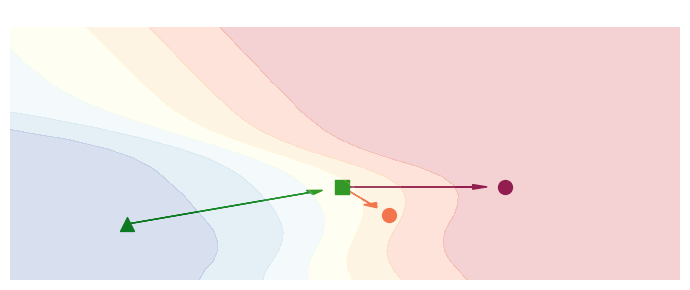

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))

palette = sns.color_palette("rocket_r", len(counterfactuals))

# plt.plot(
#     [original[0], base[0]],
#     [original[1], base[1]],
#     color="green",
#     linestyle="--",
#     alpha=1,
# )

shorten_factors = [
    0.6,
    0.8,
]  # Adjust this to control how much shorter the arrow becomes
for i, cf in enumerate(counterfactuals):
    # Plot arrow
    start = np.array(base)
    end = np.array(cf)
    direction = end - start
    new_end = start + shorten_factors[i] * direction
    plt.arrow(
        start[0],
        start[1],  # Start point
        new_end[0] - start[0],
        new_end[1] - start[1],  # Adjusted arrow vector
        head_width=0.05,
        head_length=0.05,
        fc=palette[i],
        ec=palette[i],
        alpha=1,
    )


green_start = np.array(original)
green_end = np.array(base)
green_direction = green_end - green_start
green_new_end = green_start + 0.85 * green_direction
plt.arrow(
    green_start[0],
    green_start[1],  # Start point
    green_new_end[0] - green_start[0],
    green_new_end[1] - green_start[1],  # Adjusted arrow vector
    head_width=0.05,
    head_length=0.05,
    fc="green",
    ec="green",
    alpha=1,
)

for i, cf in enumerate(counterfactuals):
    plt.scatter(
        cf[0],
        cf[1],
        label=f"delta: {deltas[i]}",
        marker="o",
        s=100,
        color=palette[i],
        alpha=1,
    )

plt.scatter(
    original[0],
    original[1],
    label="original x",
    color="green",
    marker="^",
    s=100,
    alpha=1,
)
plt.scatter(
    base[0], base[1], label="base CFE", color="green", marker="s", s=100, alpha=1
)


# Plot the decision boundary
x_min, x_max = data[0][:, 0].min() - 0.1, data[0][:, 0].max() + 0.1
y_min, y_max = data[0][:, 1].min() - 0.1, data[0][:, 1].max() + 0.1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[::, 1]
Z = classifiers[0].predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

for i in range(1, len(classifiers)):
    Z += classifiers[i].predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

Z = Z / len(classifiers)

Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.2, cmap="RdYlBu")
plt.xlim(-0.9, 1.4)
plt.ylim(-0.9, 2)

# plt.legend(ncols=2, fontsize=8, bbox_to_anchor=(0.79, 0.9), labelspacing=1)

# Turn off the grid, ticks, and lines
plt.grid(False)
plt.tick_params(left=False, bottom=False)
plt.xticks([])
plt.yticks([])


# remove the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tight_layout()
plt.savefig(
    "images/paper/moons_robust_counterfactuals_clean.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [ ]:
def get_background():
    # Just plot the background
    fig, ax = plt.subplots(1, 1, figsize=(20, 15))

    # Plot the decision boundary
    x_min, x_max = data[0][:, 0].min(), data[0][:, 0].max()
    y_min, y_max = data[0][:, 1].min(), data[0][:, 1].max()

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    # Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[::, 1]
    Z = classifiers[0].predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    for i in range(1, len(classifiers)):
        Z += classifiers[i].predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1] ** 0.5

    Z = Z / len(classifiers)

    Z = Z.reshape(xx.shape)

    # Draw the decision boundary with a thick black line
    plt.contour(xx, yy, Z, levels=[0.6], linewidths=3, colors="black", linestyles="--")
    plt.contourf(xx, yy, Z, alpha=0.5, cmap="RdYlBu")

    # Turn off the grid, ticks, and lines
    plt.grid(False)
    plt.tick_params(left=False, bottom=False)
    plt.xticks([])
    plt.yticks([])
    # remove the frame
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    return fig, ax


(<Figure size 2000x1500 with 1 Axes>, <Axes: >)

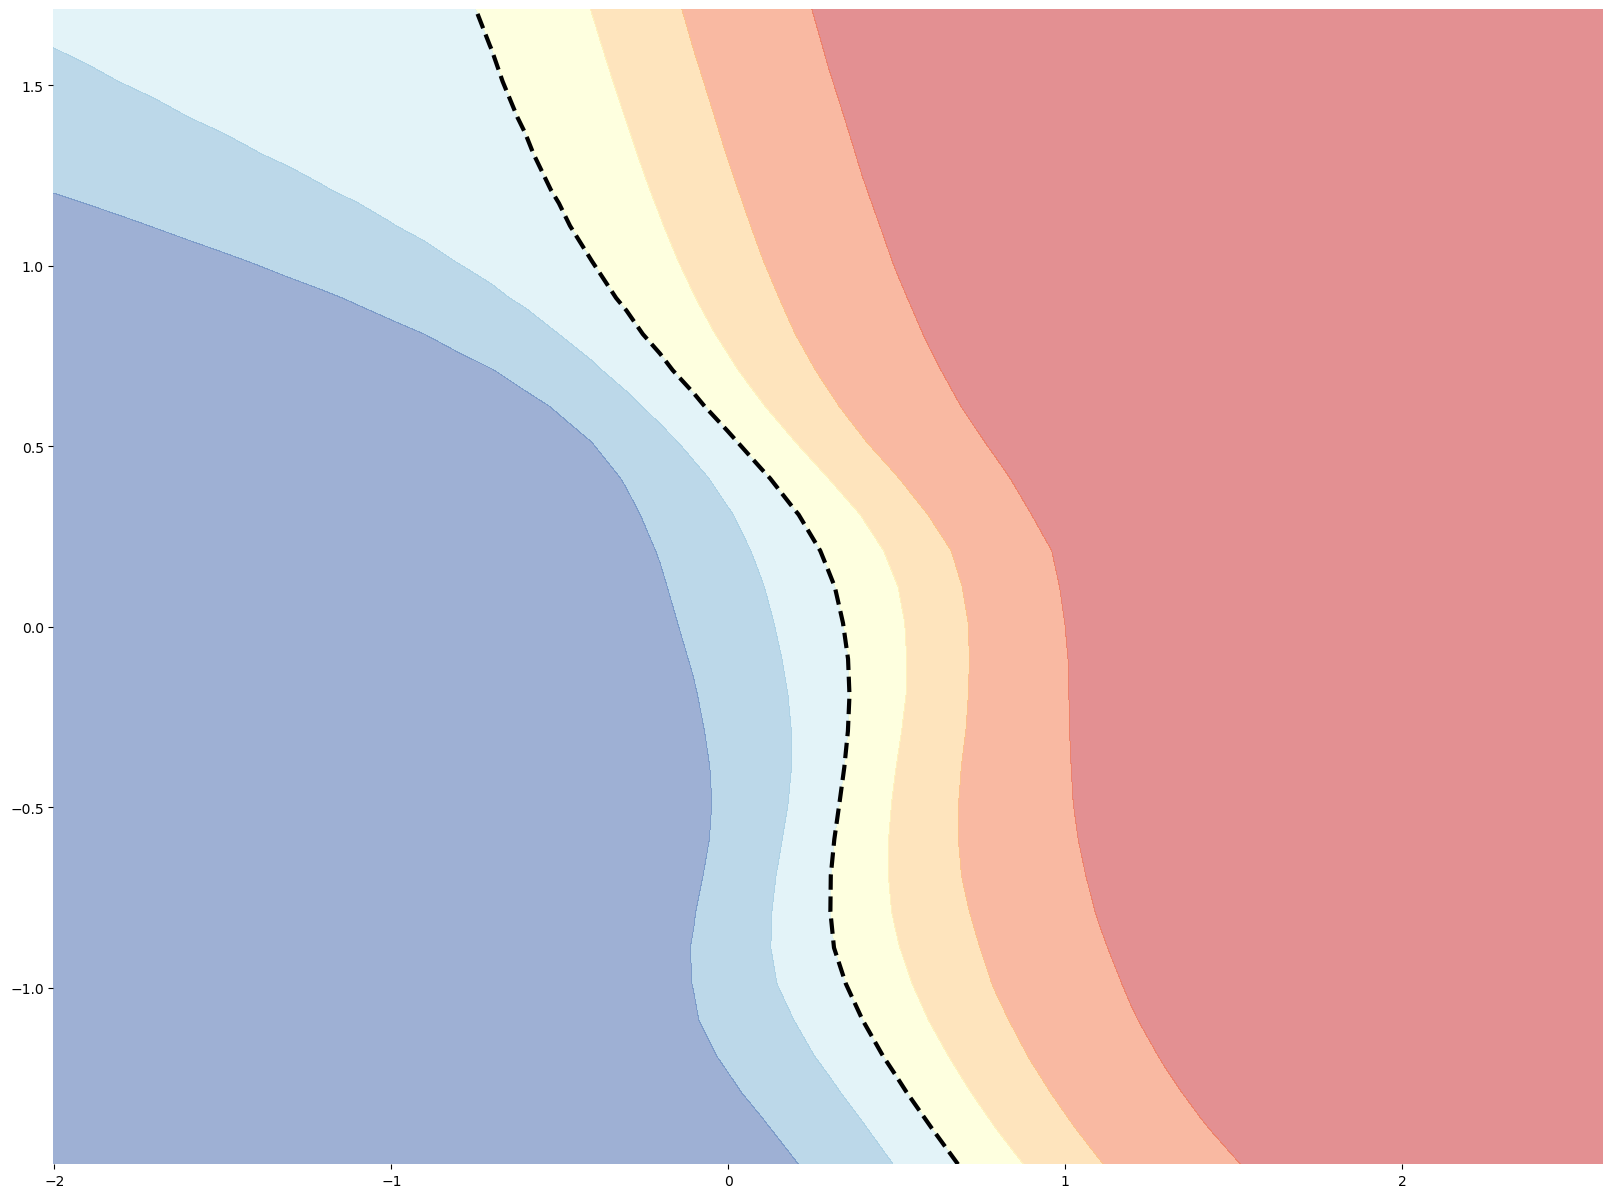

In [29]:
get_background()

In [64]:
base_x = [-1, -0.5]
base_cf = [0.5, -0.3]

In [ ]:
def figure1():
    # get the background
    fig, ax = get_background()

    # Add the base x
    plt.scatter(
        base_x[0], base_x[1], label="Base x", color="black", marker="o", s=200, alpha=1
    )

    # Add the base cf
    plt.scatter(
        base_cf[0],
        base_cf[1],
        label="Base CF",
        color="white",
        marker="o",
        s=200,
        alpha=1,
        edgecolors="black",
        linewidth=3,
    )

    # Draw the arrow
    plt.arrow(
        base_x[0] + 0.05,
        base_x[1] + 0.005,
        base_cf[0] - base_x[0] - 0.15,
        base_cf[1] - base_x[1] - 0.02,
        head_width=0.05,
        head_length=0.05,
        fc="black",
        ec="black",
        alpha=1,
        linestyle="-",
        linewidth=3,
    )

    return fig, ax

Original data point (black) and the base counterfactual explanation (white with black border)


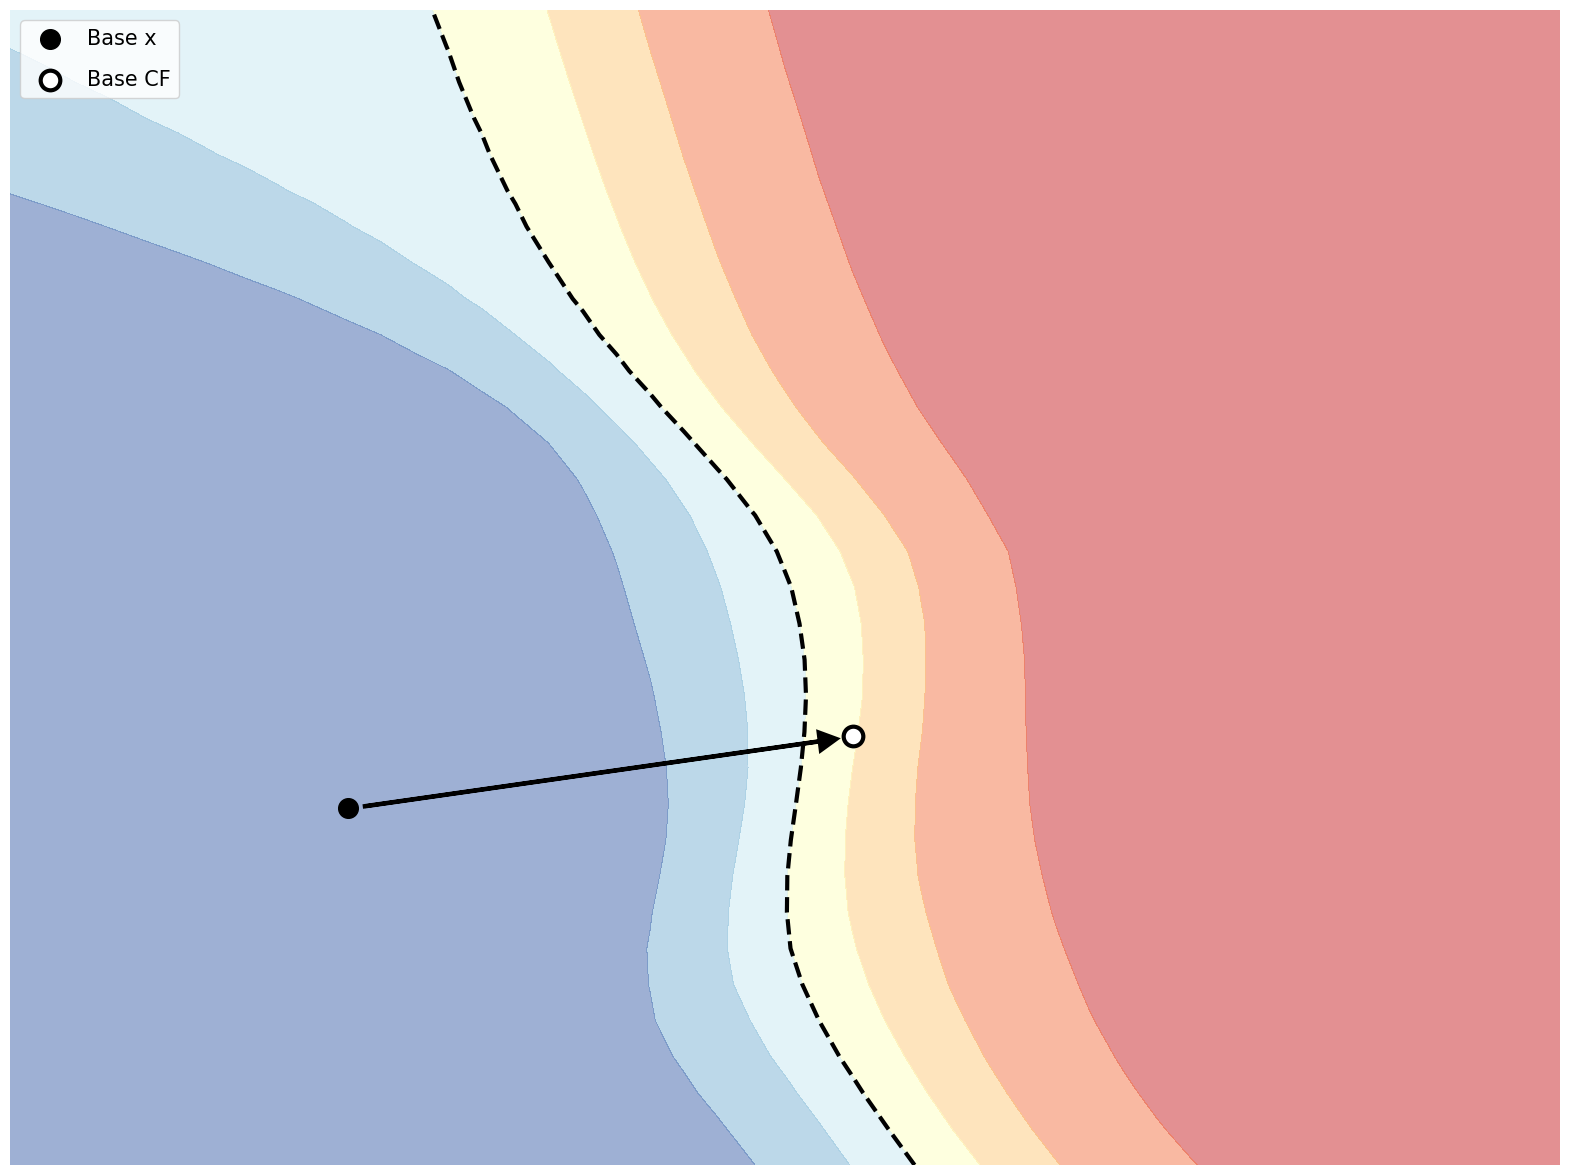

In [79]:
figure1()
plt.legend(fontsize=15, labelspacing=1, loc="upper left")
caption = """Original data point (black) and the base counterfactual explanation (white with black border)"""
print(caption)
plt.savefig("images/paper/figure1.png", dpi=300, bbox_inches="tight")

In [212]:
def figure2():
    fig, ax = figure1()
    r = 0.5
    rs = np.array([0.47, 0.4, 0.3, 0.2, 0.3])
    theta = [0, 4, 1, 7, 2.8]

    x = rs * np.cos(theta) + base_cf[0]
    y = rs * np.sin(theta) + base_cf[1]

    circle = plt.Circle(
        (base_cf[0], base_cf[1]),
        r,
        color="gray",
        fill=True,
        linestyle="--",
        linewidth=3,
        alpha=0.5,
        label="Sampling region",
    )

    plt.scatter(
        x,
        y,
        color="gray",
        marker="o",
        s=200,
        alpha=1,
        edgecolors="black",
        linewidth=3,
        label="Candidates",
    )

    samples = zip(x, y)

    ax.add_artist(circle)
    return fig, ax, samples

Candidates for the counterfactual explanation (gray)


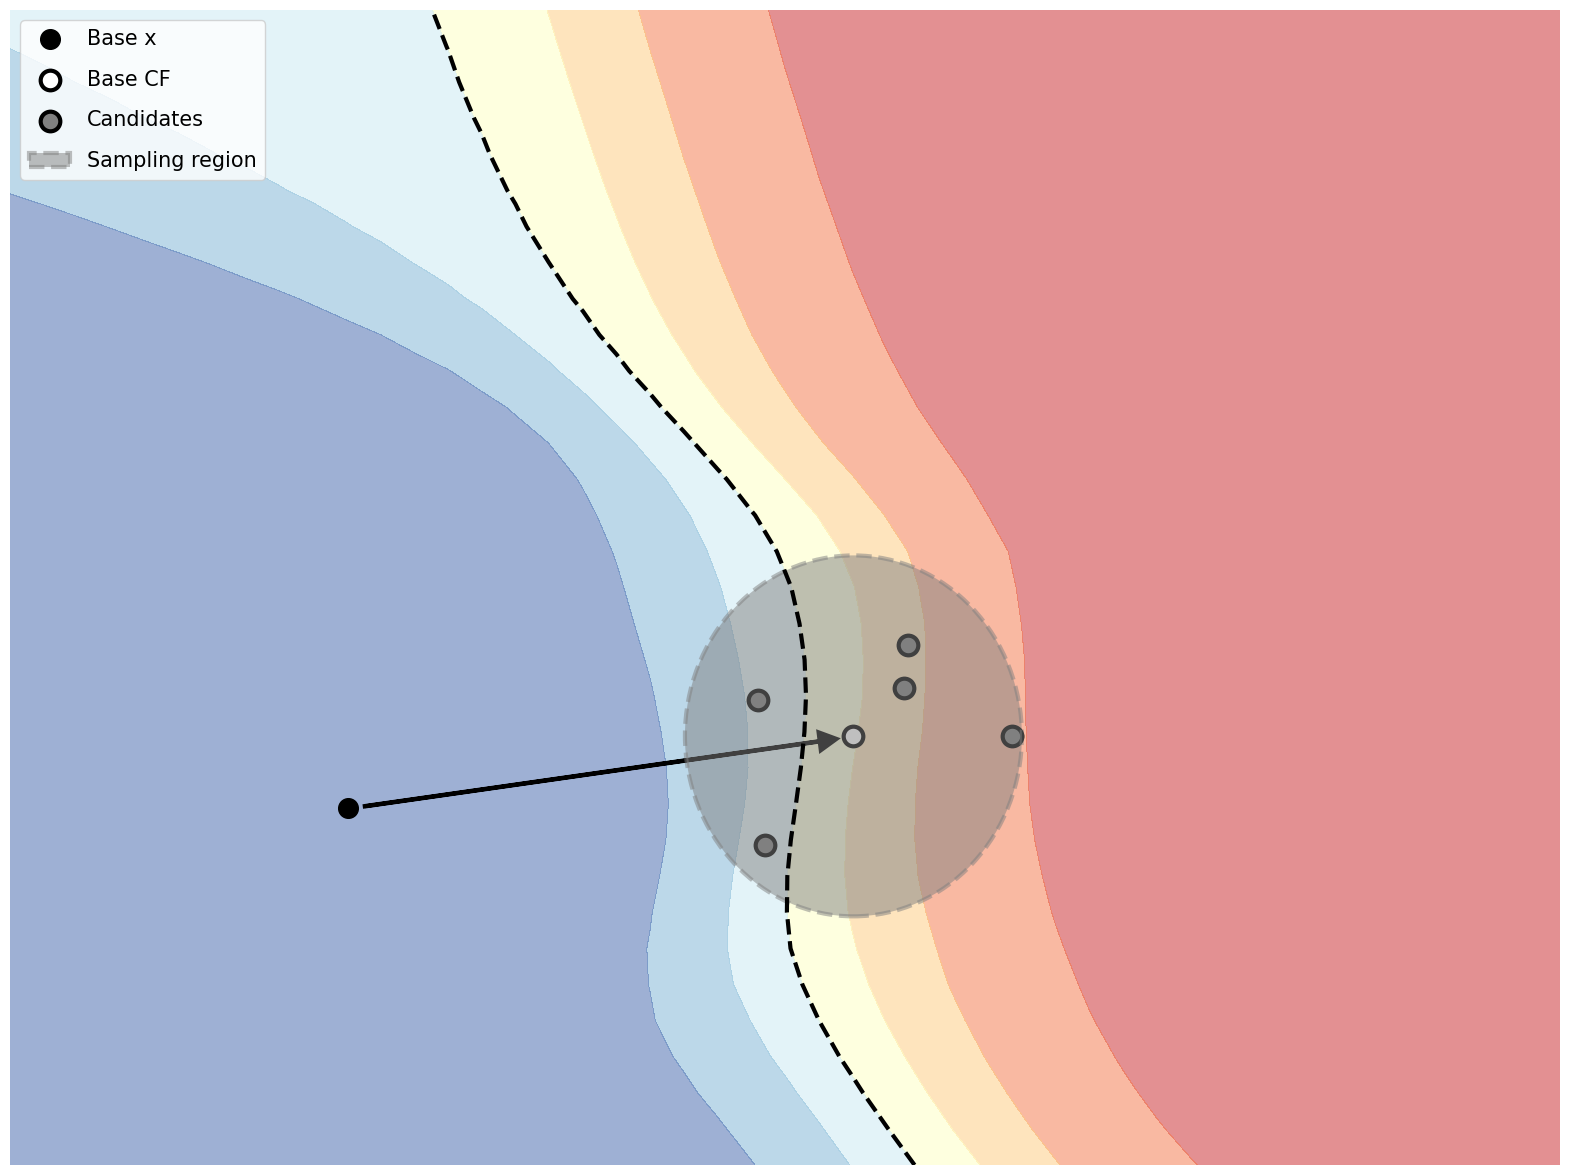

In [213]:
figure2()
plt.legend(fontsize=15, labelspacing=1, loc="upper left")
caption = """Candidates for the counterfactual explanation (gray)"""
print(caption)
plt.savefig("images/paper/figure2.png", dpi=300, bbox_inches="tight")

Valid and invalid candidates for the counterfactual explanation


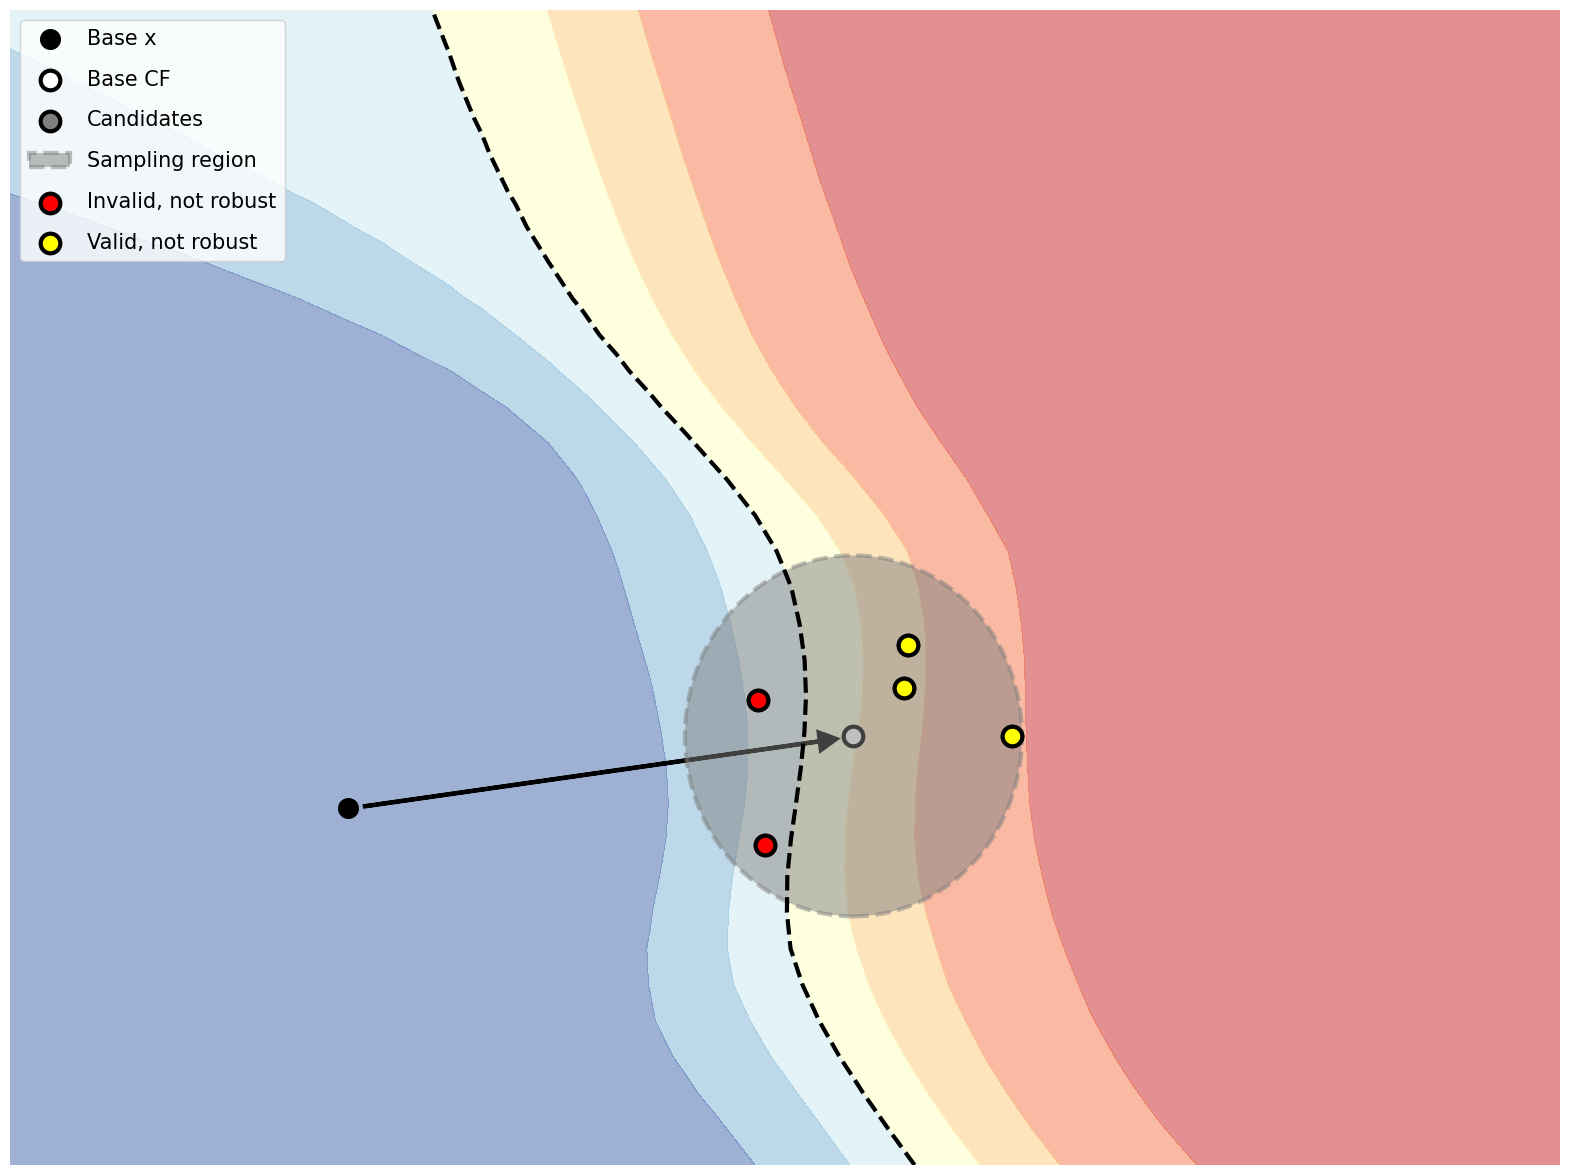

In [214]:
fig, ax, samples = figure2()
samples = np.array(list(samples))
# Change the color of the samples if they are to the left of the base cf

mask = samples[:, 0] < base_cf[0] - 0.1
mask = mask.astype(int)
plt.scatter(
    samples[:, 0][mask == 1],
    samples[:, 1][mask == 1],
    color="red",
    marker="o",
    s=200,
    alpha=1,
    edgecolors="black",
    linewidth=3,
    label="Invalid, not robust",
)

plt.scatter(
    samples[:, 0][mask == 0],
    samples[:, 1][mask == 0],
    color="yellow",
    marker="o",
    s=200,
    alpha=1,
    edgecolors="black",
    linewidth=3,
    label="Valid, not robust",
)

plt.legend(fontsize=15, labelspacing=1, loc="upper left")
caption = """Valid and invalid candidates for the counterfactual explanation"""
print(caption)
plt.savefig("images/paper/figure3.png", dpi=300, bbox_inches="tight")

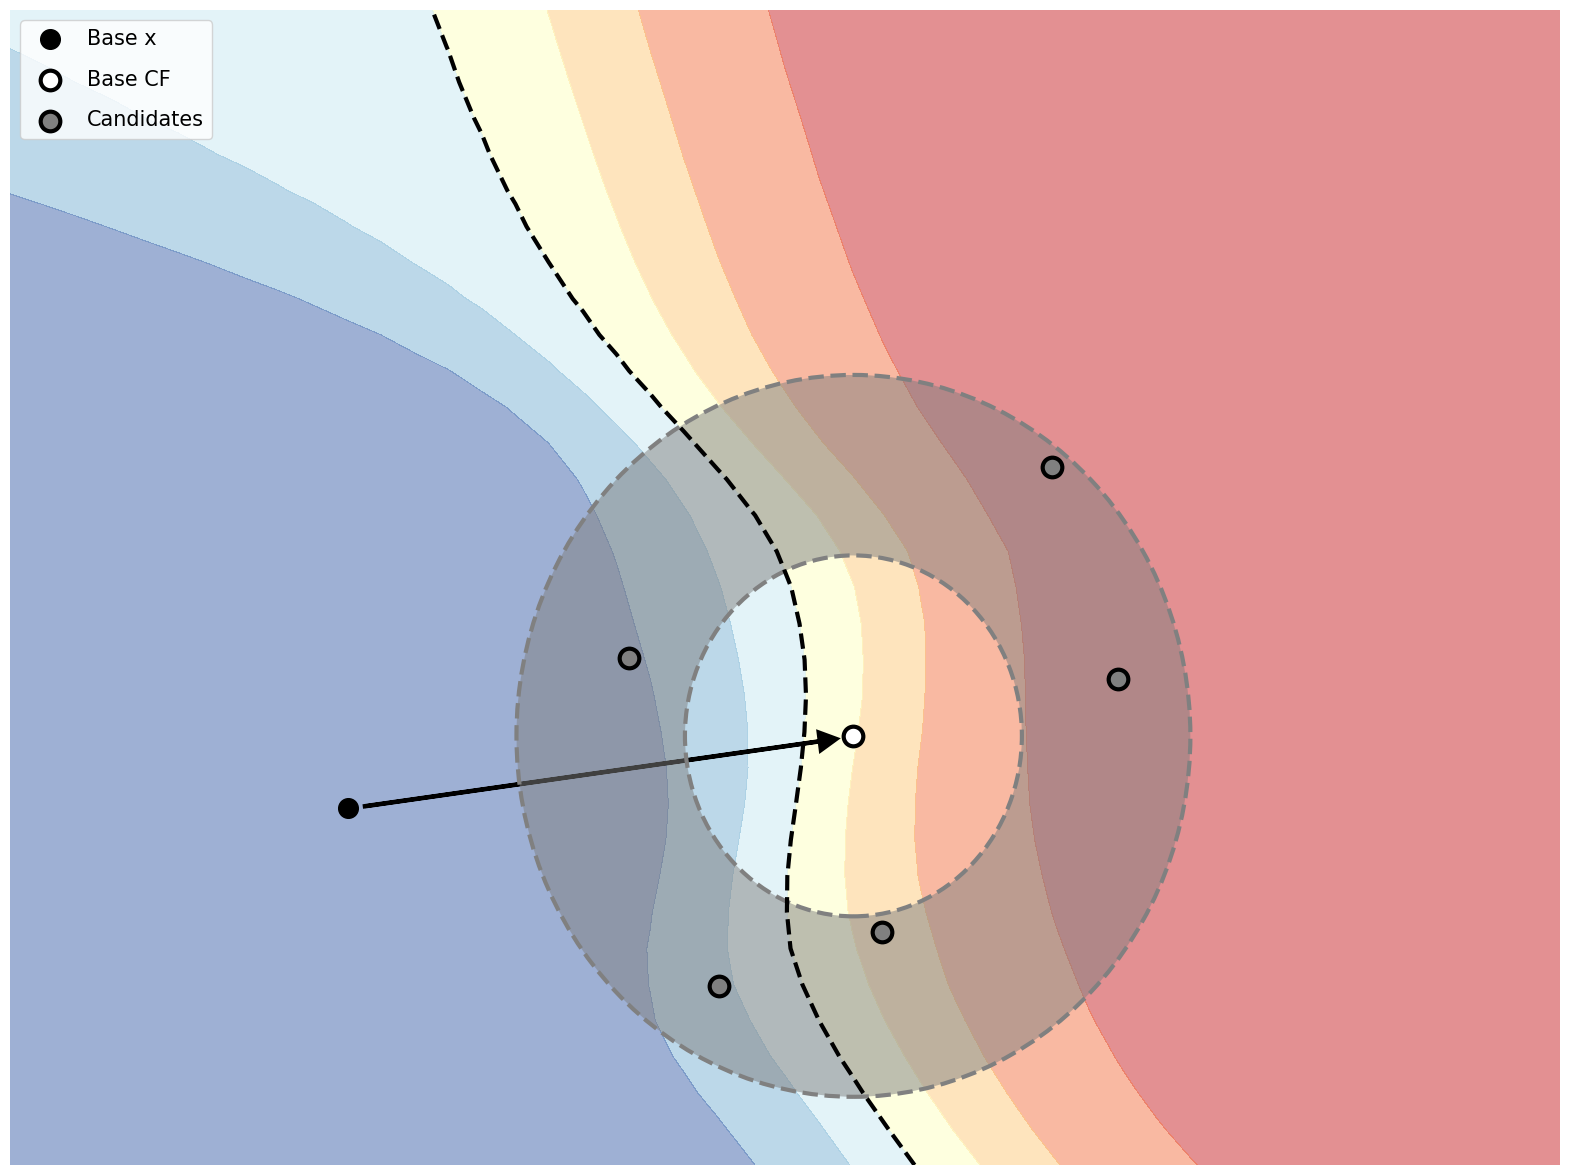

In [251]:
def figure4():
    # Now we revert back to raw candidates but we draw a bigger circle around the base cf
    fig, ax = figure1()

    rs = np.array([0.8, 0.95, 0.55, 0.7, 0.8])
    r = 1.0
    r_small = 0.5
    theta = [0.2, 0.9, 3.1 * np.pi / 2, 0.9 * np.pi, 8 * np.pi / 6]

    x = rs * np.cos(theta) + base_cf[0]
    y = rs * np.sin(theta) + base_cf[1]

    circle = plt.Circle(
        (base_cf[0], base_cf[1]),
        r,
        color="gray",
        fill=False,
        linestyle="--",
        linewidth=3,
    )

    circle_small = plt.Circle(
        (base_cf[0], base_cf[1]),
        r_small,
        color="gray",
        fill=False,
        linestyle="--",
        linewidth=3,
    )

    # Fill the area between the outer and inner circle
    # Do it as a polygon of the two circles
    samples_outer = np.linspace(0, 2 * np.pi, 100)
    samples_inner = np.linspace(0, 2 * np.pi, 100)

    x_outer = r * np.cos(samples_outer) + base_cf[0]
    y_outer = r * np.sin(samples_outer) + base_cf[1]

    x_inner = r_small * np.cos(samples_inner) + base_cf[0]
    y_inner = r_small * np.sin(samples_inner) + base_cf[1]

    polygon_x = np.concatenate([x_outer, x_inner[::-1]])
    polygon_y = np.concatenate([y_outer, y_inner[::-1]])

    f = plt.fill(polygon_x, polygon_y, color="gray", alpha=0.5)
    f[0].set_edgecolor("none")

    plt.scatter(
        x,
        y,
        color="gray",
        marker="o",
        s=200,
        alpha=1,
        edgecolors="black",
        linewidth=3,
        label="Candidates",
    )

    ax.add_artist(circle)
    ax.add_artist(circle_small)

    return fig, ax, zip(x, y)


figure4()
plt.legend(fontsize=15, labelspacing=1, loc="upper left")
plt.savefig("images/paper/figure4.png", dpi=300, bbox_inches="tight")

Valid and invalid candidates for the counterfactual explanation


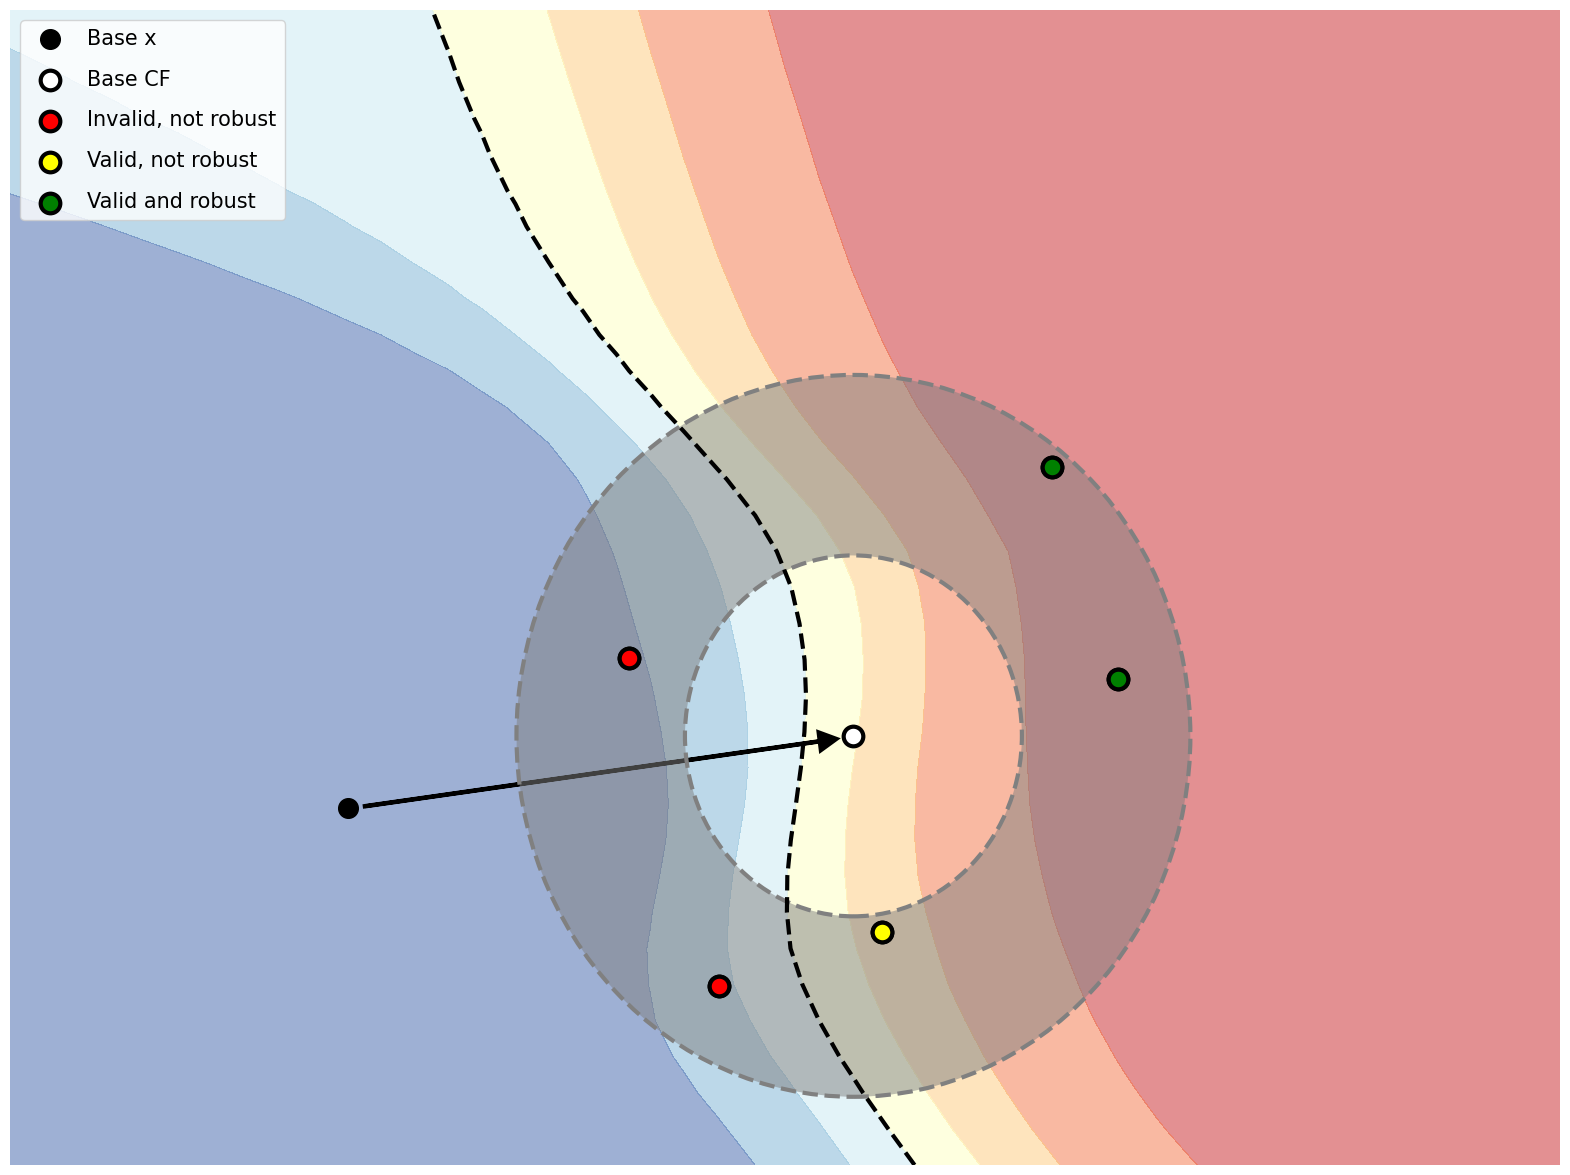

In [ ]:
def figure5():
    fig, ax, samples = figure4()

    samples = np.array(list(samples))
    # Change the color of the samples if they are to the left of the base cf

    mask = samples[:, 0] < base_cf[0] - 0.1
    mask = mask.astype(int)

    plt.scatter(
        samples[:, 0][mask == 1],
        samples[:, 1][mask == 1],
        color="red",
        marker="o",
        s=200,
        alpha=1,
        edgecolors="black",
        linewidth=3,
        label="Invalid, not robust",
    )

    mask2 = (samples[:, 0] > base_cf[0]) & (samples[:, 0] < base_cf[0] + 0.2)
    mask2 = mask2.astype(int)

    plt.scatter(
        samples[:, 0][mask2 == 1],
        samples[:, 1][mask2 == 1],
        color="yellow",
        marker="o",
        s=200,
        alpha=1,
        edgecolors="black",
        linewidth=3,
        label="Valid, not robust",
    )

    plt.scatter(
        samples[:, 0][(mask == 0) & (mask2 == 0)],
        samples[:, 1][(mask == 0) & (mask2 == 0)],
        color="green",
        marker="o",
        s=200,
        alpha=1,
        edgecolors="black",
        linewidth=3,
        label="Valid and robust",
    )

    robust_samples = samples[(mask == 0) & (mask2 == 0)]
    return fig, ax, robust_samples


fig, ax, robust_samples = figure5()
# skip the third elemnt from legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles[:2] + handles[3:],
    labels[:2] + labels[3:],
    fontsize=15,
    labelspacing=1,
    loc="upper left",
)

# plt.legend(fontsize=15, labelspacing=1, loc="upper left")
caption = """Valid and invalid candidates for the counterfactual explanation"""
print(caption)
plt.savefig("images/paper/figure5.png", dpi=300, bbox_inches="tight")

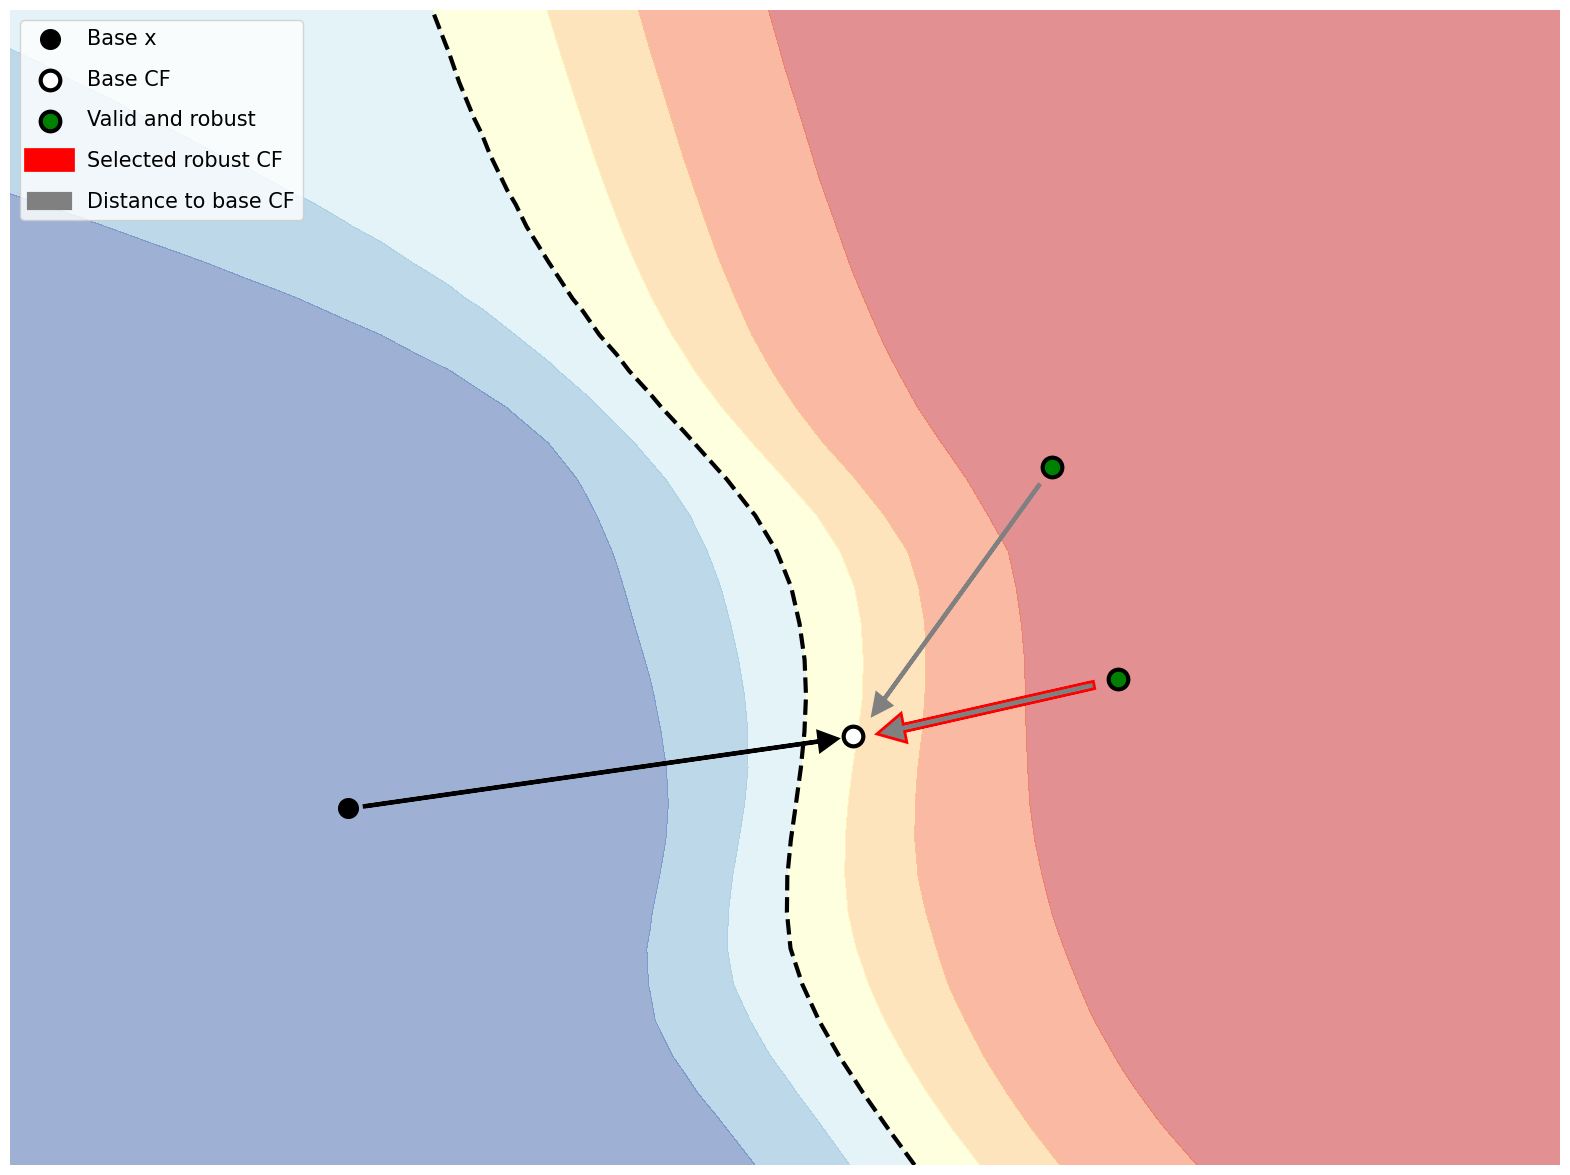

In [315]:
fig, ax = figure1()

plt.scatter(
    robust_samples[:, 0],
    robust_samples[:, 1],
    color="green",
    marker="o",
    s=200,
    alpha=1,
    edgecolors="black",
    linewidth=3,
    label="Valid and robust",
)

# Select arrow 1 by highlighting its outline in red via a trick
# which is to plot the arrow again with a bigger linewidth
plt.arrow(
    robust_samples[0][0] - 0.08,
    robust_samples[0][1] - 0.02,
    base_cf[0] - robust_samples[0][0] + 0.22,
    base_cf[1] - robust_samples[0][1] + 0.04,
    head_width=0.05,
    head_length=0.05,
    fc="red",
    ec="red",
    alpha=1,
    linestyle="-",
    linewidth=7,
    label="Selected robust CF",
)

# Draw the arrow from robust samples to base cf
arr1 = plt.arrow(
    robust_samples[0][0] - 0.08,
    robust_samples[0][1] - 0.02,
    base_cf[0] - robust_samples[0][0] + 0.22,
    base_cf[1] - robust_samples[0][1] + 0.04,
    head_width=0.05,
    head_length=0.05,
    fc="gray",
    ec="gray",
    alpha=1,
    linestyle="-",
    linewidth=3,
    label="Distance to base CF",
)

arr2 = plt.arrow(
    robust_samples[1][0] - 0.04,
    robust_samples[1][1] - 0.05,
    base_cf[0] - robust_samples[1][0] + 0.13,
    base_cf[1] - robust_samples[1][1] + 0.15,
    head_width=0.05,
    head_length=0.05,
    fc="gray",
    ec="gray",
    alpha=1,
    linestyle="-",
    linewidth=3,
)


plt.legend(fontsize=15, labelspacing=1, loc="upper left")
plt.savefig("images/paper/figure6.png", dpi=300, bbox_inches="tight")